# __Final Project: Adding captions to your photos__

__Install__

```sh
pip install kaggle
```

__Download__

```sh
kaggle datasets download -d adityajn105/flickr8k
```

__Extract__

```sh
tar -xf flickr8k.zip
```
```

### __Libraries__

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import sentencepiece as spm
from torch.nn.utils.rnn import pack_padded_sequence
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### __Dataframe Creation__

In [2]:
# Read the captions CSV file into a DataFrame
captions_file = 'captions.txt'
df = pd.read_csv(captions_file)

# Shuffle if desired
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
unique_images = df['image'].unique()

train_images, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)

# Create train and test DataFrames by filtering
train_df = df[df['image'].isin(train_images)].reset_index(drop=True)
test_df = df[df['image'].isin(test_images)].reset_index(drop=True)
df = train_df

In [3]:
df

,image,caption
0,2973269132_252bfd0160.jpg,A large wild cat is pursuing a horse across a ...
1,270263570_3160f360d3.jpg,Two brown dogs fight on the leafy ground .
2,2053006423_6adf69ca67.jpg,A man in shorts is standing on a rock looking ...
3,512101751_05a6d93e19.jpg,a muzzled white dog is running on the grass .
4,3156406419_38fbd52007.jpg,A person skiing downhill .
...,...,...
32355,2220175999_081aa9cce8.jpg,Two big dogs wade in the ocean
32356,2555622234_3e531e4014.jpg,A wet German Shepherd runs along the waves on ...
32357,525887861_4cc7a1beca.jpg,Little girl in pink skateboard .
32358,1204996216_71d7519d9a.jpg,A boy lays on a picnic table bench .


In [4]:
test_df

,image,caption
0,3512033861_a357bb58b6.jpg,a very large group of people standing crowded ...
1,3498997518_c2b16f0a0e.jpg,Football players on a feild the one on the lef...
2,3399798295_a452963365.jpg,Two women with their arms around each other sm...
3,3549006919_3604bc813e.jpg,a man wearing a yellow helmet climbing the sid...
4,2244024374_54d7e88c2b.jpg,Two dogs fight over a stick in a flooded field .
...,...,...
8090,2771424045_1fdf9617eb.jpg,A young woman poses with a man in face paint .
8091,3536561454_e75993d903.jpg,A man skateboards around an orange cone .
8092,3039675864_0b7961844d.jpg,"A street with pigeons , a motorcyclist and a w..."
8093,3413806271_17b7e102aa.jpg,The people in the red parasail are gliding ove...


### __Using Google's sentencepiece library to create (essentially) vocab.itos and vocab.stoi (torchtext had incompatibility issues with torch CUDA installations)__

In [5]:
captions_only = df['caption'].tolist()

# Write them to a text file (one caption per line)
with open('captions_only.txt', 'w', encoding='utf-8') as f:
    for c in captions_only:
        f.write(c.strip() + '\n')

# Now you have vocab.itos and vocab.stoi

In [6]:
spm.SentencePieceTrainer.train(
    input='captions_only.txt',
    model_prefix='m',         # will generate m.model and m.vocab
    vocab_size=5725,
    character_coverage=1.0,   # use full character coverage
    model_type='unigram',     # can also try bpe or others
    user_defined_symbols=['<pad>', '<start>', '<end>'] # optional
)

sp = spm.SentencePieceProcessor()
sp.load('m.model')

True

In [7]:
text = "A child in a pink dress is climbing up a set of stairs in an entry way."
token_ids = sp.encode_as_ids(text.lower())
pieces = sp.encode_as_pieces(text.lower())
print("Token IDs:", token_ids)
print("Subword Pieces:", pieces)

Token IDs: [6, 60, 9, 6, 111, 198, 15, 165, 69, 6, 418, 19, 488, 9, 46, 2427, 38, 987, 1027]
Subword Pieces: ['▁a', '▁child', '▁in', '▁a', '▁pink', '▁dress', '▁is', '▁climbing', '▁up', '▁a', '▁set', '▁of', '▁stairs', '▁in', '▁an', '▁entr', 'y', '▁way', '.']


In [8]:
# stoi
stoi = {}
# itos will be a list of pieces in order
itos = [sp.id_to_piece(i) for i in range(sp.get_piece_size())]

for i, piece in enumerate(itos):
    stoi[piece] = i

In [9]:
stoi

{'<unk>': 0,
 '<s>': 1,
 '</s>': 2,
 '<pad>': 3,
 '<start>': 4,
 '<end>': 5,
 '▁a': 6,
 '▁.': 7,
 '▁A': 8,
 '▁in': 9,
 's': 10,
 '▁the': 11,
 'ing': 12,
 '▁on': 13,
 '▁': 14,
 '▁is': 15,
 '▁dog': 16,
 '▁with': 17,
 '▁man': 18,
 '▁of': 19,
 'and': 20,
 'o': 21,
 '▁Tw': 22,
 '▁girl': 23,
 '▁white': 24,
 '▁black': 25,
 '▁boy': 26,
 '▁are': 27,
 '▁The': 28,
 '▁woman': 29,
 '▁,': 30,
 '▁wear': 31,
 '▁to': 32,
 'ed': 33,
 'nd': 34,
 '▁at': 35,
 '▁water': 36,
 '▁red': 37,
 'y': 38,
 '▁brown': 39,
 '▁young': 40,
 '▁his': 41,
 '▁people': 42,
 '▁blue': 43,
 '▁grass': 44,
 '▁running': 45,
 '▁an': 46,
 '▁through': 47,
 '▁shirt': 48,
 '▁snow': 49,
 '▁playing': 50,
 '▁dogs': 51,
 '▁while': 52,
 'e': 53,
 '▁hold': 54,
 '▁ball': 55,
 '▁down': 56,
 '▁standing': 57,
 'le': 58,
 '▁jumping': 59,
 '▁child': 60,
 '▁over': 61,
 'd': 62,
 '▁litt': 63,
 '▁stand': 64,
 'front': 65,
 '▁person': 66,
 '▁sitting': 67,
 '▁field': 68,
 '▁up': 69,
 '▁two': 70,
 '▁small': 71,
 '▁large': 72,
 '▁green': 73,
 '▁her': 74,


In [10]:
itos

['<unk>',
 '<s>',
 '</s>',
 '<pad>',
 '<start>',
 '<end>',
 '▁a',
 '▁.',
 '▁A',
 '▁in',
 's',
 '▁the',
 'ing',
 '▁on',
 '▁',
 '▁is',
 '▁dog',
 '▁with',
 '▁man',
 '▁of',
 'and',
 'o',
 '▁Tw',
 '▁girl',
 '▁white',
 '▁black',
 '▁boy',
 '▁are',
 '▁The',
 '▁woman',
 '▁,',
 '▁wear',
 '▁to',
 'ed',
 'nd',
 '▁at',
 '▁water',
 '▁red',
 'y',
 '▁brown',
 '▁young',
 '▁his',
 '▁people',
 '▁blue',
 '▁grass',
 '▁running',
 '▁an',
 '▁through',
 '▁shirt',
 '▁snow',
 '▁playing',
 '▁dogs',
 '▁while',
 'e',
 '▁hold',
 '▁ball',
 '▁down',
 '▁standing',
 'le',
 '▁jumping',
 '▁child',
 '▁over',
 'd',
 '▁litt',
 '▁stand',
 'front',
 '▁person',
 '▁sitting',
 '▁field',
 '▁up',
 '▁two',
 '▁small',
 '▁large',
 '▁green',
 '▁her',
 '▁yellow',
 '▁by',
 '▁group',
 '▁walking',
 '-',
 '▁into',
 '▁beach',
 '▁near',
 '▁mouth',
 '▁air',
 '▁children',
 '▁men',
 '▁one',
 '▁jumps',
 '▁another',
 '▁for',
 '▁its',
 '▁rock',
 '▁Thre',
 'n',
 '▁other',
 '▁runs',
 '▁street',
 '▁sit',
 '▁riding',
 '▁bike',
 '▁walk',
 'm',
 '▁play',

In [11]:
pad_id = sp.piece_to_id('<pad>')
start_id = sp.piece_to_id('<start>')
end_id = sp.piece_to_id('<end>')
unk_id = sp.unk_id()  # usually 0 by default

print(f'pad_id: {pad_id}, start_id: {start_id}, end_id: {end_id}, unk_id: {unk_id}')

pad_id: 3, start_id: 4, end_id: 5, unk_id: 0


### __Creating the loaded dataset from the Flickr8k Dataset__

In [12]:
class FlickrDataset(Dataset):
    def __init__(self, df, img_folder, transform=None, max_len=80):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
        self.max_len = max_len

        # If you want a train/val split, you can filter df here.
        # Here we use entire df for demonstration.
        self.images = self.df['image'].values
        self.captions = self.df['caption'].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        caption_text = self.captions[idx]

        # Load image
        img_path = os.path.join(self.img_folder, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption text to indices
        pieces = sp.encode_as_pieces(caption_text.lower().strip())
        caption_ids = [start_id] + [stoi.get(p, unk_id) for p in pieces] + [end_id]

        # Pad or truncate to max_len
        if len(caption_ids) < self.max_len:
            caption_ids += [pad_id] * (self.max_len - len(caption_ids))
        else:
            caption_ids = caption_ids[:self.max_len]

        length = sum([1 for token in caption_ids if token != pad_id])

        return image, torch.tensor(caption_ids), length
    
# Define a collate_fn to handle variable lengths
def collate_fn(batch):
    # batch: list of (image, caption, length)
    images = [item[0] for item in batch]
    captions = [item[1] for item in batch]
    lengths = [item[2] for item in batch]

    images = torch.stack(images, 0)
    captions = torch.stack(captions, 0)
    lengths = torch.tensor(lengths, dtype=torch.int64)

    return images, captions, lengths

In [13]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),(0.229,0.224,0.225))
])

dataset = FlickrDataset(df, img_folder='Images', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

### __CNN + LSTM Architecture__

In [14]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        # remove the last fc layer
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, images):
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, max_seq_length=80, itos=None):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size, padding_idx=pad_id)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        self.itos = itos

    def forward(self, features, captions, lengths):
        # captions include <start>, ..., <end>
        # lengths is count of all non-pad tokens in captions
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        
        # Use lengths as is
        packed = pack_padded_sequence(embeddings, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, _ = self.lstm(packed)
        outputs = self.linear(outputs[0])
        return outputs
    
    def predict(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)

        for i in range(self.max_seq_length):
            hiddens, states = self.lstm(inputs, states)
            outputs = self.linear(hiddens.squeeze(1))
            _, predicted = outputs.max(1)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted).unsqueeze(1)

        sampled_ids = torch.stack(sampled_ids, 1)

        # Convert word_ids to words using itos
        sentences = []
        for sample_id in sampled_ids:
            sample_id = sample_id.cpu().numpy()
            sampled_caption = []
            for word_id in sample_id:
                word = self.itos[word_id]
                if word == '<end>':
                    break
                if word not in ['<start>', '<pad>', '<end>']:
                    sampled_caption.append(word)
            # Join the subwords or decode with SentencePiece if desired
            sentence = ''.join(sampled_caption).replace('▁', ' ').strip()
            sentences.append(sentence)
        return sentences

### __Training__

In [ ]:
embed_size = 256
hidden_size = 512
num_layers = 1
learning_rate = 0.001
num_epochs = 20  # just as an example

encoder = EncoderCNN(embed_size=embed_size).to(device)
decoder = DecoderRNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=len(itos), num_layers=num_layers, itos=itos).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=pad_id)
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(dataloader):
        images = images.to(device)
        captions = captions.to(device)
        lengths = lengths.to(device)

        # Forward pass
        features = encoder(images)
        outputs = decoder(features, captions, lengths)

        # Because we used pack_padded_sequence, outputs is already the right shape
        # But we need to adjust the target as well (exclude the feature timestep)
        targets = pack_padded_sequence(captions[:, 1:], lengths.cpu(), batch_first=True, enforce_sorted=False)[0]

        loss = criterion(outputs, targets)

        # Backprop and optimize
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i}], Loss: {loss.item():.4f}")

print("Training completed.")

c:\Users\yashh\Downloads\aipi-590-project4\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\yashh\Downloads\aipi-590-project4\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [0/20], Step [0], Loss: 8.6703
Epoch [0/20], Step [100], Loss: 4.6305
Epoch [0/20], Step [200], Loss: 4.3310
Epoch [0/20], Step [300], Loss: 4.2364
Epoch [0/20], Step [400], Loss: 4.0035
Epoch [0/20], Step [500], Loss: 4.1494
Epoch [0/20], Step [600], Loss: 4.0285
Epoch [0/20], Step [700], Loss: 4.0002
Epoch [0/20], Step [800], Loss: 3.7150
Epoch [0/20], Step [900], Loss: 3.8041
Epoch [0/20], Step [1000], Loss: 3.9419
Epoch [1/20], Step [0], Loss: 3.6131
Epoch [1/20], Step [100], Loss: 3.8216
Epoch [1/20], Step [200], Loss: 3.4331
Epoch [1/20], Step [300], Loss: 3.5358
Epoch [1/20], Step [400], Loss: 3.3863
Epoch [1/20], Step [500], Loss: 3.3431
Epoch [1/20], Step [600], Loss: 3.4964
Epoch [1/20], Step [700], Loss: 3.4403
Epoch [1/20], Step [800], Loss: 3.5768
Epoch [1/20], Step [900], Loss: 3.5999
Epoch [1/20], Step [1000], Loss: 3.5102
Epoch [2/20], Step [0], Loss: 3.1770
Epoch [2/20], Step [100], Loss: 3.2102
Epoch [2/20], Step [200], Loss: 2.9566
Epoch [2/20], Step [300], Los

### __Example Caption!__

Image: 2098646162_e3b3bbf14c.jpg
Predicted Caption: a a black a white bear a a dogss .
Reference Captions: ['Two black and white dogs are looking at a grey and white kitty .', 'Two black and white dogs looking at a black and white kitten who is sitting on top of a tank with hoses on it .', 'A black and gray cat stands on a contracption while two big dogs stare at it .', 'Two dogs are staring at a grey and white cat .', 'Two black and white dogs look at a kitten perched on some equipment .']
-------------------------------------------


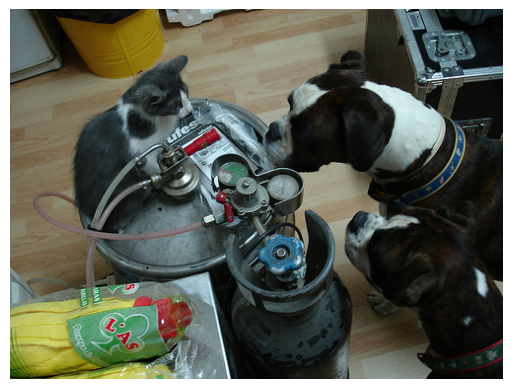

Image: 492341908_1ef53be265.jpg
Predicted Caption: two a a racends a car a aons a another take a .
Reference Captions: ['Two kids are posing on a black ATV that is on top of sand .', 'Two young girls drive an ATV .', 'Two girls are sitting on an ATV on the sand in front of a bridge .', 'Two girls are riding a 4 wheeler .', 'Two girls riding an ATV .']
-------------------------------------------


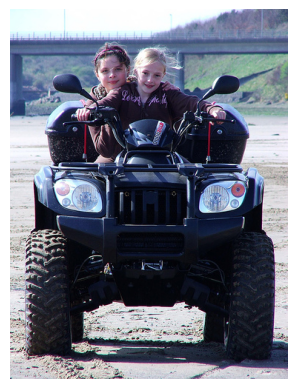

Image: 3399028417_50a621274c.jpg
Predicted Caption: the look at inter bus .
Reference Captions: ['A bunch of people are talking down a city street with old buildings on both sides of them .', 'People walking on a street .', 'Group of people crossing a street with building surrounding them .', 'Crowd of people in street lined with tall tan buildings .', 'A crowded street in Italy .']
-------------------------------------------


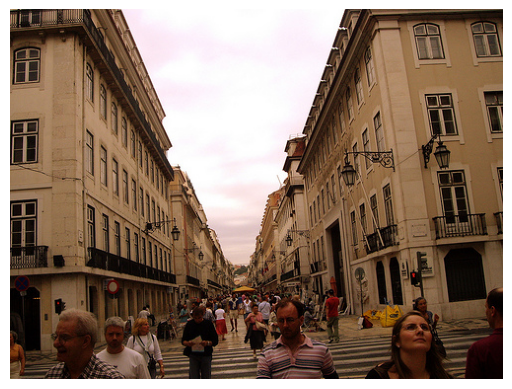

Image: 1434005938_ad75c8598c.jpg
Predicted Caption: a childing a on of withsnd in field are under trees the treesnd ofons trees
Reference Captions: ['A man is carrying a large backpack and looking over some green fields .', 'a man wears a backpack .', 'Person with a backpack in a field', 'A person wearing a blue backpack stands on a field above a scenic view .', 'A man with a large hiking backpack outside']
-------------------------------------------


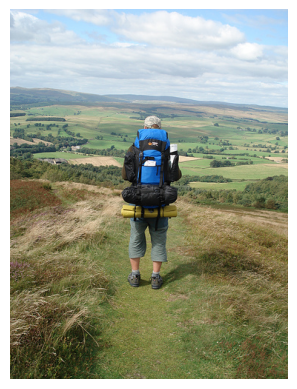

Image: 3124838157_7ef96745b7.jpg
Predicted Caption: a ofs a of a stand a a woman a a woman a a stand look at in background
Reference Captions: ['A man and two women pose outside a retail store .', 'three people standing outside a store window with two large signs in the background', 'Two tall men and a short woman standing in front of a store that is having a closeout', "A short woman poses between two tall men in front of a store that 's going out of busines .", 'Three people stand in front of a store window and smile .']
-------------------------------------------


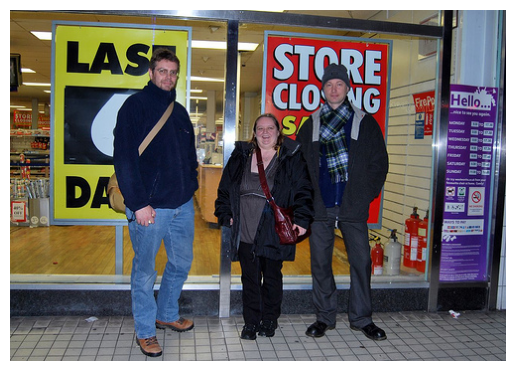

In [20]:
import matplotlib.pyplot as plt

# Ensure models are in evaluation mode
encoder.eval()
decoder.eval()

# Sample 5 random images from the test dataframe
sample_images = test_df['image'].drop_duplicates().sample(n=5)

for img_name in sample_images:
    # Load and preprocess the image
    img_path = os.path.join('Images', img_name)
    image = Image.open(img_path).convert('RGB')
    original_image = image.copy()  # Keep a copy to display
    
    # Apply the same transforms as in training
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        # Extract features and generate caption
        features = encoder(image)
        caption = decoder.predict(features)  # returns a list of captions
        predicted_caption = caption[0]

    # Get reference captions from the dataframe
    refs = test_df[test_df['image'] == img_name]['caption'].tolist()

    # Print image name, predicted caption, and references
    print("Image:", img_name)
    print("Predicted Caption:", predicted_caption)
    print("Reference Captions:", refs)
    print("-------------------------------------------")

    # Display the image
    plt.imshow(original_image)
    plt.axis('off')
    plt.show()

### __BLEU Score & Analyzing Overfitting__

In [17]:
chencherry = SmoothingFunction()

def evaluate_bleu(encoder, decoder, df, transform, device, split_name="data"):
    references_list = []
    predictions_list = []
    images = df['image'].unique()

    encoder.eval()
    decoder.eval()

    for img_name in images:
        # Get all ground truth (reference) captions for this image
        ref_caps = df[df['image'] == img_name]['caption'].tolist()
        # Tokenize references
        ref_tokens = [c.lower().split() for c in ref_caps]

        # Load and preprocess the image
        img_path = os.path.join('Images', img_name)
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        with torch.no_grad():
            features = encoder(image)

        predicted_captions = decoder.predict(features)
        predicted_caption = predicted_captions[0]

        # Tokenize the predicted caption
        candidate_tokens = predicted_caption.lower().split()

        references_list.append(ref_tokens)
        predictions_list.append(candidate_tokens)

    # Apply smoothing function for BLEU calculation
    bleu_score = corpus_bleu(
        references_list, 
        predictions_list, 
        smoothing_function=chencherry.method1
    )
    print(f"{split_name} Corpus BLEU score:", bleu_score)
    return bleu_score

# After you have re-trained for more epochs and reloaded the best model:
test_bleu = evaluate_bleu(encoder, decoder, test_df, transform, device, split_name="Test")

# If you have a train_df
train_bleu = evaluate_bleu(encoder, decoder, df, transform, device, split_name="Train")

# Compare BLEU scores to assess overfitting
print("Difference (Train BLEU - Test BLEU):", train_bleu - test_bleu)

Test Corpus BLEU score: 0.002944330970627164
Train Corpus BLEU score: 0.004507607714948055
Difference (Train BLEU - Test BLEU): 0.001563276744320891


__TODO__
* Changing the model architecture, e.g. include an attention module.

__Since transformed-based image captioning is far more computational and time intensive on my GPU, I have decided not to do the comparison. (resources are not permitted)__